## Setup and Imports

In [ ]:
!pip install -Uq transformers
!pip install -Uq datasets evaluate wandb peft

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
os.environ["WANDB_PROJECT"] = "timm-wrapper"

import numpy as np
import torch

from datasets import load_dataset
from matplotlib import pyplot as plt

from transformers.image_utils import load_image
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)
from peft import LoraConfig, get_peft_model

from functools import partial

import evaluate

import wandb

In [ ]:
wandb.login()

## Dataset

In [ ]:
train_ds = load_dataset("food101", split="train[:10000]")
val_ds = load_dataset("food101", split="validation[:1000]")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
print(f"Number of training examples: {len(train_ds)}")
print(f"Number of validation examples: {len(val_ds)}")

Number of training examples: 10000
Number of validation examples: 1000


In [ ]:
labels = train_ds.features["label"].names
num_labels = len(labels)
print(f"Number of labels: {num_labels}")

# Build the dictionaries for easier query
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[i] = label

Number of labels: 101


### Visualize the dataset

In [ ]:
def display_image_grid(images, labels, rows=2, cols=5, figsize=(12, 6), target_size=(128, 128), after_aug=False):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if after_aug:
            image = images[i]
            image = image.permute(1, 2, 0)
            image = image.clip(min=0.0, max=1.0)
        else:
            image = images[i].resize((128, 128))
        ax.imshow(image)
        ax.set_title(labels[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

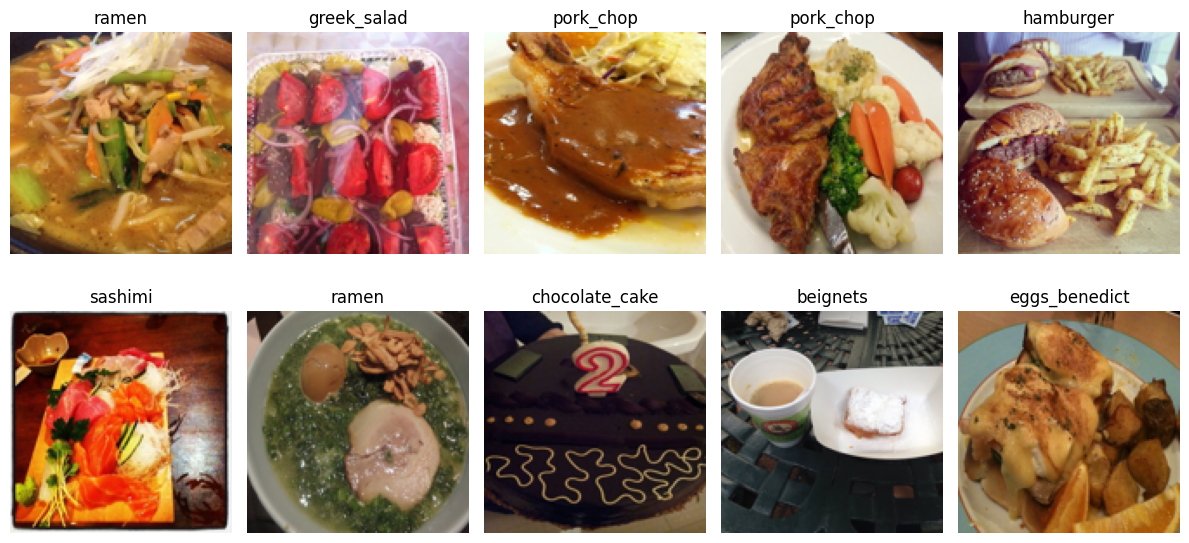

In [ ]:
samples = train_ds.shuffle().select(range(10))
sample_images = samples["image"]
sample_labels = [id2label[id] for id in samples["label"]]
display_image_grid(sample_images, sample_labels)

## Dataset Transforms for Traning

In [ ]:
checkpoint = "timm/vit_base_patch16_224.augreg2_in21k_ft_in1k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

In [ ]:
train_transforms = image_processor.train_transforms
val_transforms = image_processor.val_transforms

def apply_transforms(examples, train_aug=False):
    if train_aug:
        examples["pixel_values"] = [train_transforms(img.convert("RGB")) for img in examples["image"]]
    else:
        examples["pixel_values"] = [val_transforms(img.convert("RGB")) for img in examples["image"]]

    del examples["image"]
    return examples

In [ ]:
train_ds = train_ds.with_transform(partial(apply_transforms, train_aug=True))
val_ds = val_ds.with_transform(apply_transforms)

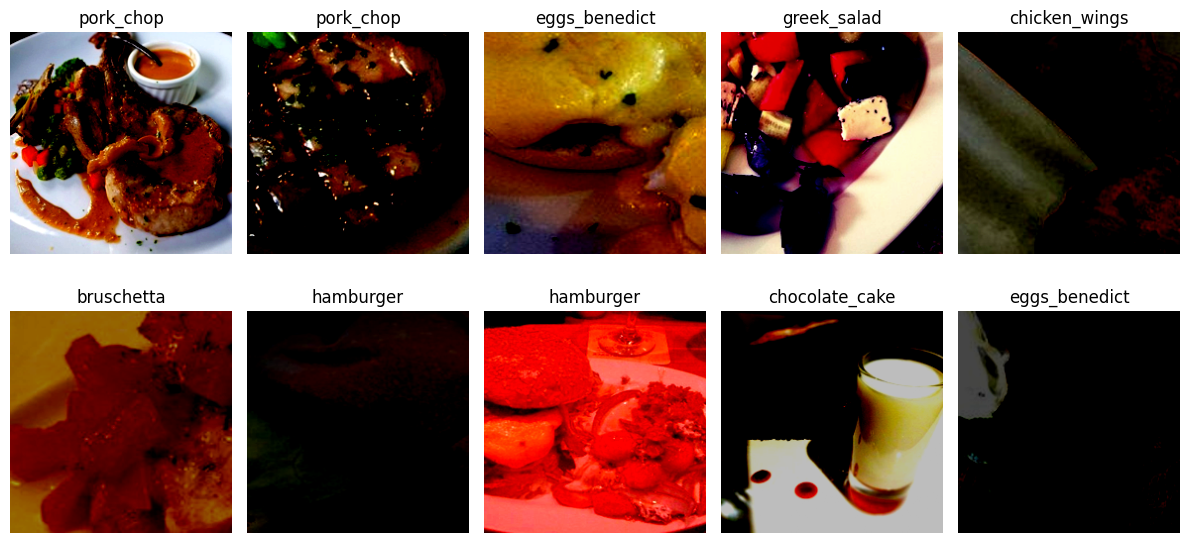

In [ ]:
samples = train_ds.shuffle().select(range(10))
sample_images = [s["pixel_values"] for s in samples]
sample_labels = [id2label[s["label"]] for s in samples]

# After augmentation
display_image_grid(sample_images, sample_labels, after_aug=True)

## Model

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of TimmWrapperForImageClassification were not initialized from the model checkpoint at timm/vit_base_patch16_224.augreg2_in21k_ft_in1k and are newly initialized because the shapes did not match:
- head.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- head.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

TimmWrapperForImageClassification(
  (timm_model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act)

In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["qkv"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["head"],
)
lora_model = get_peft_model(model, config)

lora_model.print_trainable_parameters()

trainable params: 667,493 || all params: 86,543,818 || trainable%: 0.7713


## Training

In [ ]:
learning_rate = 5e-3
batch_size = 128
num_epochs = 5
output_dir = f"ariG23498/{checkpoint.split('/')[1]}.lora_ft_food101"

In [ ]:
print(output_dir)

ariG23498/vit_base_patch16_224.augreg2_in21k_ft_in1k.lora_ft_food101


In [ ]:
accuracy = evaluate.load("accuracy")
data_collator = DefaultDataCollator()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
    report_to="wandb",
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

In [ ]:
train_result = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: aritra_hf (success-hf). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,1.176900,0.095076,0.971000
2,1.005100,0.051970,0.979000
3,0.650600,0.066527,0.980000
4,0.496700,0.044699,0.981000


The `save_pretrained` method is disabled for TimmWrapperImageProcessor. The image processor configuration is saved directly in `config.json` when `save_pretrained` is called for saving the model.
No files have been modified since last commit. Skipping to prevent empty commit.


In [ ]:
model.push_to_hub("ariG23498/food-before-lora")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ariG23498/food-before-lora/commit/52a257e9aaac813ee35f5f37214e60a41853b9f1', commit_message='Upload TimmWrapperForImageClassification', commit_description='', oid='52a257e9aaac813ee35f5f37214e60a41853b9f1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ariG23498/food-before-lora', endpoint='https://huggingface.co', repo_type='model', repo_id='ariG23498/food-before-lora'), pr_revision=None, pr_num=None)

## Inference on Test Data

In [ ]:
image = load_image("https://cdn.britannica.com/52/128652-050-14AD19CA/Maki-zushi.jpg")
inputs = image_processor(image, return_tensors="pt")

In [ ]:
with torch.no_grad():
    logits = lora_model(**inputs).logits
    labels = logits.argmax(-1).item()

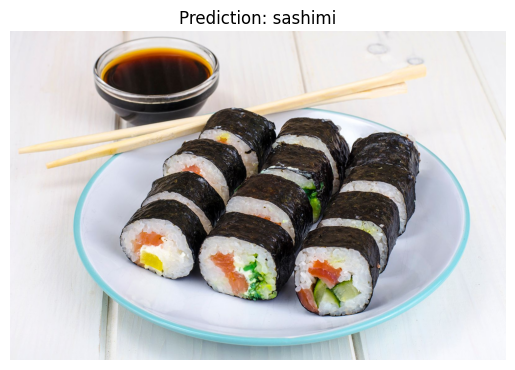

In [ ]:
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {id2label[labels]}")
plt.show()